In [1]:
%run initialising.ipynb
from matplotlib.ticker import MultipleLocator
import researchpy as rp
import itertools
import statsmodels.api as sm
import statsmodels

In [2]:
def get_antimere_df(df, full_antimere, threshold, material, constant_n_obs):
    '''
    Args:
        df:
        measure_type:
        threshold:
        constant_n_obs:
    Returns:
        DataFrame with 4x columns – 'antimere', '%acc', 'material', 'measure_type'
    '''
    
    measure_type = re.search('\.\w+', full_antimere).group()
    antimere = re.search('\d\d-\d\d', full_antimere).group()
    
    if not constant_n_obs:
        amDf = pd.DataFrame(getColumn(df, full_antimere, threshold, material)).dropna()
    else:
        if '7' in antimere:
            l = ['%s%s %%acc' % (antimere, x) for x in ['.ctd', '.ct', '.gm']]
        else:
            l = ['%s%s %%acc' % (antimere, x) for x in MEASURE_TYPES] # e.g. ['13-23.cc %acc', '13-23.ctd %acc', '13-23.ct %acc', '13-23.gm %acc']

        amDf = getThresholdDf(df, False, threshold, material)[l].dropna() #df with 4 columns of %acc for xx-xx.ctd/.cc/.gm/.ct all above threshold; dropna() means NaN values in any measure_type will cause all measure_types to be excluded              
        amDf = pd.DataFrame(amDf[full_antimere]) # df with 1 column 'xx-xx.xx %acc'
    amDf = amDf.rename(columns = lambda x: str(x)[-4:]) # df with 1 column '%acc'
    amDf['antimere'] = antimere
    amDf['material'] = material
    amDf['measure_type'] = measure_type
    
    return amDf

/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


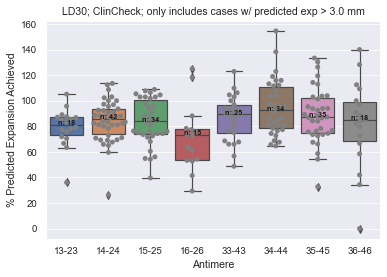

/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


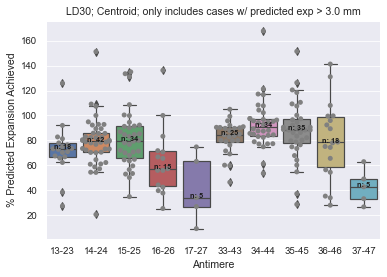

/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 11.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


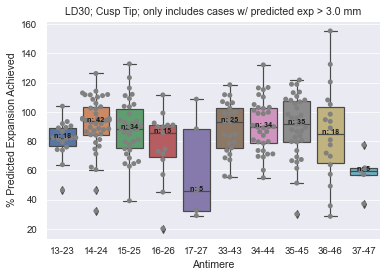

/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/Richard/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


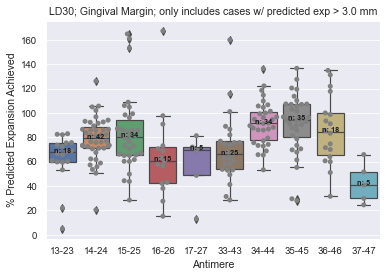

In [3]:
def boxPlot(df, measure_type, threshold, material, constant_n_obs=True):
    '''Boxplot: %Accuracy vs Antimere for a given measure_type & material.
    Only includes data where predicted exp > threshold.
    Also outputs .PDF of data.
    
    Args:
        df:
        measure_type:
        threshold:
        material:
        constant_n_obs:
            True –
                n is equal for each antimere across different measure_types
                (e.g. if pt 111 has NaN value for 16-26.ctd, then will
                exclude 16-26.gm/.ct/.cc measurements)
            False – 
                includes all cases screened by other parameters (threshold)
                mainly, if NaN value exists for xx-xx.ctd, this does not impact
                whether other measure_types of xx-xx are included.
    '''
    
    pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/boxplots-%s%s.pdf' % (material, measure_type)))
    
    sns.set('paper', font_scale=0.9)
#     sns.set_style('whitegrid', {'grid.linestyle':'--'})
#     sns.set_style('ticks', {'xtick.color':'0',
#                            'ytick.color':'0'})
    f = plt.figure()
    
    newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'material'])
    
    for i, j in zip([1, 3], [2, 4]):
        for toothNum in range(3, 8):
            
            if measure_type == '.cc' and toothNum == 7:
                continue
            
            antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
            full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)
            
            amDf = get_antimere_df(df, full_antimere, threshold, material, constant_n_obs)
            newDf = pd.concat([newDf, amDf], ignore_index=True)

    ax = sns.boxplot(x='antimere', y='%acc', data=newDf)
    ax = sns.swarmplot(x='antimere', y='%acc', data=newDf, color="grey")
    
    ### Adding n to boxplot.
    # Calculate number of obs & median to position labels
    medians = newDf.groupby(['antimere'])['%acc'].median().values
    nobs = newDf.groupby(['antimere'])['%acc'].count().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
        horizontalalignment='center', size='x-small', color='k', weight='semibold')
    
    ## formatting
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    
    # Set titles
    ax.axes.set_title("%s; %s; only includes cases w/ predicted exp > %s mm" % (material, measure_type_dict[measure_type], threshold))
    ax.set_xlabel("Antimere")
    ax.set_ylabel("% Predicted Expansion Achieved")
    
    plt.show()
    pp.savefig(f, bbox_inches="tight")
    pp.close()
    return

for measure_type in MEASURE_TYPES:
    boxPlot(df, measure_type, THRESHOLD, 'LD30')

In [4]:
amDf = get_antimere_df(df, '13-23.ctd %acc', 3, 'LD30', True).head()
amDf2 = get_antimere_df(df, '13-23.ct %acc', 3, 'LD30', True).head()

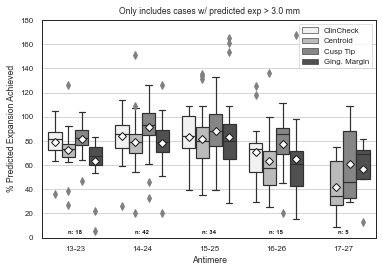

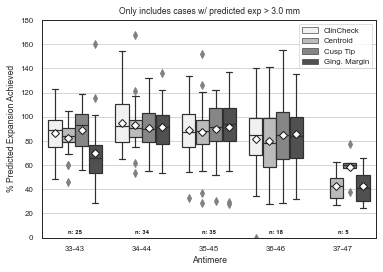

Antimere: 13-23
               F Value  Num DF  Den DF    Pr > F
measure_type  9.524144     3.0    51.0  0.000042

Antimere: 14-24
                F Value  Num DF  Den DF        Pr > F
measure_type  18.509635     3.0   123.0  5.656188e-10

Antimere: 15-25
               F Value  Num DF  Den DF    Pr > F
measure_type  2.930596     3.0    99.0  0.037316

Antimere: 16-26
               F Value  Num DF  Den DF    Pr > F
measure_type  3.638511     3.0    42.0  0.020203

Antimere: 17-27
               F Value  Num DF  Den DF    Pr > F
measure_type  2.788057     2.0     8.0  0.120575

Antimere: 33-43
               F Value  Num DF  Den DF    Pr > F
measure_type  8.629516     3.0    72.0  0.000057

Antimere: 34-44
               F Value  Num DF  Den DF    Pr > F
measure_type  0.428186     3.0    99.0  0.733243

Antimere: 35-45
               F Value  Num DF  Den DF    Pr > F
measure_type  0.704483     3.0   102.0  0.551499

Antimere: 36-46
               F Value  Num DF  Den DF    Pr > F
measu

In [10]:
def multi_measures_grouped_boxplot(df, threshold, material, constant_n_obs=True):
    '''Grouped Boxplot: %Accuracy vs Antimere grouped by material (LD30 vs EX30), for a given measure_type;
    Only includes data where predicted exp > threshold.
    Also outputs .PDF of data.'''
    
    # sns.set('poster', font_scale=1.1) 
    sns.set_theme('paper', style='white', font_scale=0.9)
    
    newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'measure_type'])
    
    for measure_type in MEASURE_TYPES:
        for i, j in zip([1, 3], [2, 4]):
            
            
            ######## CHANGE THIS IF U WANT TO INCLUDE 7s
            ######## for toothNum in range(3, 8):
            
            for toothNum in range(3, 8):

                if measure_type == '.cc' and toothNum == 7:
                    continue

                antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
                full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)

                amDf = get_antimere_df(df, full_antimere, threshold, material, constant_n_obs)
                newDf = pd.concat([newDf, amDf], ignore_index=False, sort=False)
                
    mxArch = '13-23|14-24|15-25|16-26|17-27' #['13-23','14-24','15-25','16-26','17-27']
    mdArch = '33-43|34-44|35-45|36-46|37-47' #['33-43','34-44','35-45','36-46','37-47']
    
    archDfs = []
    
    for arch in [mxArch, mdArch]:
        
        archDf = newDf[newDf['antimere'].str.contains(arch, regex=True)]
        
        archDfs.append(archDf)
        
        if arch == mxArch:
            pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/multi-measures-grouped-boxplots-%s-%s.pdf' % (material, 'Mx')))
        else:
            pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/multi-measures-grouped-boxplots-%s-%s.pdf' % (material, 'Md')))

        f = plt.figure()
        
        
        
        sns.set_context(rc={'lines.markeredgewidth': 1.5}) ## This must be here else there are no marker edges
        ax = sns.boxplot(x='antimere', y='%acc', hue='measure_type', data=archDf, showmeans=True, color='#505050',
                         meanprops={'marker':'D',"markerfacecolor":"w", 'markeredgecolor':'k'},
                         flierprops={'marker':'d', 'markerfacecolor':'grey', 'markeredgecolor':'grey'}
                        )
        
        ### Adding n to boxplot.
        # Calculate number of obs & median to position labels
        medians = archDf.groupby(['antimere'])['%acc'].median().values
        nobs = archDf.groupby(['antimere'])['%acc'].count().values.tolist() # gives total n (i.e. n×4 for each measure_type or n×3 for 2nd molars)
        nMeasures = archDf.groupby(['antimere'])['measure_type'].nunique().tolist()
        nobs = [str(int(x/y)) for x, y in zip(nobs, nMeasures)]
        nobs = ["n: " + i for i in nobs]
        # Add it to the plot
        pos = range(len(nobs))
        for tick,label in zip(pos,ax.get_xticklabels()):
            # ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
            # horizontalalignment='center', size='x-small', color='k', weight='semibold')
            
            ax.text(pos[tick], 3, nobs[tick],
            horizontalalignment='center', size='x-small', color='k', weight='semibold')
        
        ## formatting
        ax.yaxis.set_major_locator(MultipleLocator(20))
        ax.yaxis.set_minor_locator(MultipleLocator(10))
        ax.set_ylim((0, 180)) ### REMOVE LATER
        ax.yaxis.grid(True)

        # Set titles
        ax.axes.set_title("Only includes cases w/ predicted exp > %s mm" % (threshold))
        ax.set_xlabel("Antimere")
        ax.set_ylabel("% Predicted Expansion Achieved")
        
        # Set legends
        new_labels = ['ClinCheck', 'Centroid', 'Cusp Tip', 'Ging. Margin']
        for t, l in zip(ax.legend().get_texts(), new_labels): t.set_text(l)
        
        plt.show()

        pp.savefig(f, bbox_inches="tight")
        pp.close()
    
    archDf = pd.concat(archDfs, ignore_index=False, sort=False)
    archDf['id'] = archDf.index
    
    # print whether ANOVA yields significant differences
    for antimere in ANTIMERES:
        
        amDf = archDf[archDf['antimere'] == antimere]
        aovrm = statsmodels.stats.anova.AnovaRM(amDf, '%acc', 'id', within=['measure_type'])
        res = aovrm.fit()

        print('Antimere: %s\n%s\n' % (antimere, res.anova_table))    

    return archDf

archDf = multi_measures_grouped_boxplot(df, THRESHOLD, 'LD30')

In [6]:
stats.iqr(getColumn(df, '16-26.ctd %acc', 3, 'LD30', True))

27.9418367605673

In [7]:
table = rp.summary_cont(archDf.groupby(['antimere', 'measure_type'])['%acc'])
table.to_csv(os.path.join(OUTPUT_DIR, 'tables/LD30-accuracies-%s.csv' % THRESHOLD))
table

N     Mean       SD       SE  95% Conf.  Interval
antimere measure_type                                                    
13-23    .cc           18  79.1131  14.8198   3.4931    71.7434   86.4828
         .ct           18  81.6230  12.5024   2.9468    75.4058   87.8403
         .ctd          18  72.2254  20.1255   4.7436    62.2172   82.2336
         .gm           18  63.0706  20.1804   4.7566    53.0351   73.1061
14-24    .cc           42  84.3248  15.9849   2.4665    79.3436   89.3061
         .ct           42  91.3859  18.4258   2.8432    85.6440   97.1278
         .ctd          42  78.8757  19.5401   3.0151    72.7865   84.9648
         .gm           42  78.6416  17.9509   2.7699    73.0477   84.2354
15-25    .cc           34  83.3547  17.9224   3.0737    77.1013   89.6081
         .ct           34  88.4936  19.4998   3.3442    81.6898   95.2974
         .ctd          34  81.1487  23.0486   3.9528    73.1067   89.1908
         .gm           34  82.8798  30.4635   5.2244    72.2506   93.5090
16-26    .cc           15  71.0301  25.6852   6.6319    56.8061   85.2541
         .ct           15  77.3338  23.1363   5.9738    64.5214   90.1463
         .ctd          15  63.4905  27.8075   7.1799    48.0912   78.8898
         .gm           15  64.8619  35.9260   9.2761    44.9667   84.7570
17-27    .ct            5  61.0085  35.6112  15.9258    16.7913  105.2256
         .ctd           5  41.5469  26.8960  12.0282     8.1512   74.9427
         .gm            5  56.9143  27.2240  12.1749    23.1112   90.7173
33-43    .cc           25  86.4107  17.6391   3.5278    79.1296   93.6918
         .ct           25  88.8567  17.6678   3.5336    81.5638   96.1497
         .ctd          25  82.3481  13.1453   2.6291    76.9220   87.7742
         .gm           25  70.3178  27.2741   5.4548    59.0596   81.5760
34-44    .cc           34  94.6561  21.2856   3.6504    87.2292  102.0830
         .ct           34  90.6873  17.8276   3.0574    84.4670   96.9077
         .ctd          34  93.0446  19.6419   3.3686    86.1913   99.8980
         .gm           34  91.3822  17.8127   3.0548    85.1671   97.5973
35-45    .cc           35  88.7172  21.6919   3.6666    81.2658   96.1686
         .ct           35  90.0333  20.8274   3.5205    82.8788   97.1878
         .ctd          35  87.5165  23.6293   3.9941    79.3995   95.6334
         .gm           35  91.2187  23.9477   4.0479    82.9924   99.4450
36-46    .cc           18  81.7898  33.7277   7.9497    65.0174   98.5622
         .ct           18  85.1432  32.8298   7.7381    68.8174  101.4691
         .ctd          18  79.8078  31.3869   7.3980    64.1995   95.4162
         .gm           18  85.6456  28.4445   6.7044    71.5005   99.7907
37-47    .ct            5  58.6842  14.3430   6.4144    40.8750   76.4934
         .ctd           5  42.8559  14.1296   6.3190    25.3116   60.4002
         .gm            5  42.5631  16.6955   7.4664    21.8329   63.2933

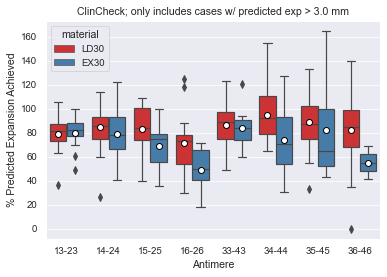

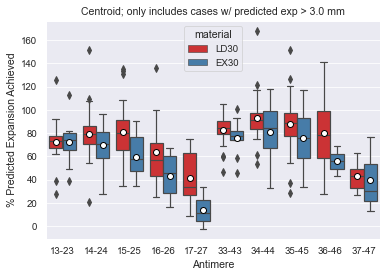

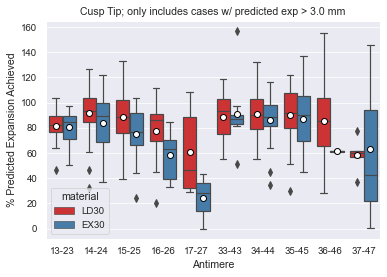

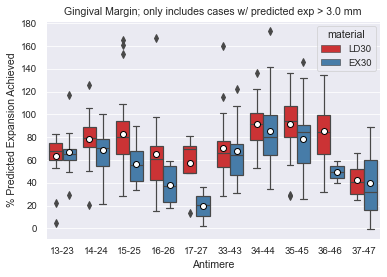

In [8]:
def LD30_vs_EX30_grouped_boxplot(df, measure_type, threshold, constant_n_obs=True):
    '''Grouped Boxplot: %Accuracy vs Antimere grouped by material (LD30 vs EX30), for a given measure_type;
    Only includes data where predicted exp > threshold.
    Also outputs .PDF of data.'''
    
    pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/LD30-vs-EX30-grouped-boxplots-%s.pdf' % (measure_type)))

    sns.set('paper', font_scale=0.9)

    f = plt.figure()    
    
    newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'material'])
    
    for material in ['LD30', 'EX30']:
        for i, j in zip([1, 3], [2, 4]):
            for toothNum in range(3, 8):
                
                if measure_type == '.cc' and toothNum == 7:
                    continue
                
                antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
                full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)

                amDf = get_antimere_df(df, full_antimere, threshold, material, constant_n_obs)
                newDf = pd.concat([newDf, amDf], ignore_index=True)
    
    ax = sns.boxplot(x='antimere', y='%acc', hue='material', data=newDf, showmeans=True, palette="Set1", 
                     meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"})

    ## formatting
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    # ax.set_ylim((-20, 200))
    
    # Set titles
    ax.axes.set_title("%s; only includes cases w/ predicted exp > %s mm" % (measure_type_dict[measure_type], threshold))
    ax.set_xlabel("Antimere")
    ax.set_ylabel("% Predicted Expansion Achieved")
    plt.show()
    
    pp.savefig(f, bbox_inches="tight")
    pp.close()
    
    return
for measure_type in MEASURE_TYPES:
    LD30_vs_EX30_grouped_boxplot(df, measure_type, THRESHOLD)